In [1]:
import os
from math import pi

# os.environ["CUDA_VISIBLE_DEVICES"] = "5, 4, 3, 1"  # Use only the first GPUos.environ["CUDA_VISIBLE_DEVICES"] = "5, 4, 3, 1"  # Use only the first GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "4, 5"  # Use only the first GPU

# os.environ["CUDA_VISIBLE_DEVICES"] = "0, 2, 4, 5, 6, 7, 8, 9"  # Use only the first GPU
from autocvd import autocvd
autocvd(num_gpus = 2)

from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX, DIRECT_ACC_LAXMAP
from odisseo.option_classes import SimulationConfig, SimulationParams, NFWParams, PlummerParams, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot

# import timeit
import time


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

In [2]:
jax.devices()

[CudaDevice(id=0),
 CudaDevice(id=1),
 CudaDevice(id=2),
 CudaDevice(id=3),
 CudaDevice(id=4),
 CudaDevice(id=5),
 CudaDevice(id=6),
 CudaDevice(id=7)]

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [6]:
# Define the 
config = SimulationConfig(N_particles=10_000, 
                          return_snapshots=False, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                 r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                 ),
                          G=G, ) 


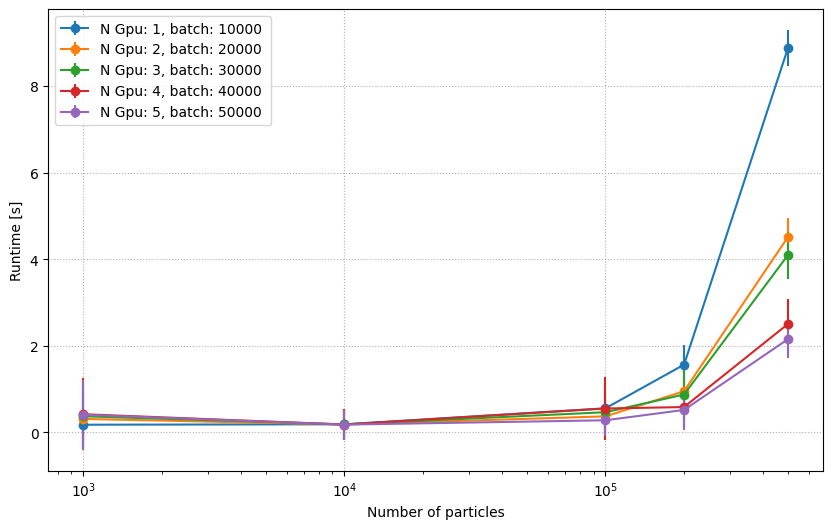

In [15]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np


plt.style.use('default')
pattern = r'\b\w*laxmap\w*\b'
dir_path = './kartick_test_data/h100/1_time_step/'
list_of_string = sorted([os.path.join(dir_path, f) for f in os.listdir(dir_path)])
matches = [s for s in list_of_string if re.search(pattern, s)]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for m in matches:
    match = re.search(r'gpu_(\d+)', m)
    gpu_num = int(match.group(1)) if match else None

    laxmap_match = re.search(r'laxmap_(\d+)', m)
    laxmap_num = int(laxmap_match.group(1)) if laxmap_match else None
    data = np.load(m, allow_pickle=True)
    if len(data) == 3:
        N_particles = [100, 1_000, 10_000]
    else:
        N_particles = [1_000, 10_000, 100_000, 200_000, 500_000 ]
    ax.errorbar(N_particles, data[:, 0], yerr=data[:, 1], label=f'N Gpu: {gpu_num}, batch: {laxmap_num} ', marker='o', linestyle='-')
ax.set_xlabel('Number of particles')
ax.set_ylabel('Runtime [s]')
ax.set_xscale('log')
ax.grid(linestyle='dotted')
ax.legend()
fig.savefig('./laxmap_scalability_1step.pdf', bbox_inches='tight')

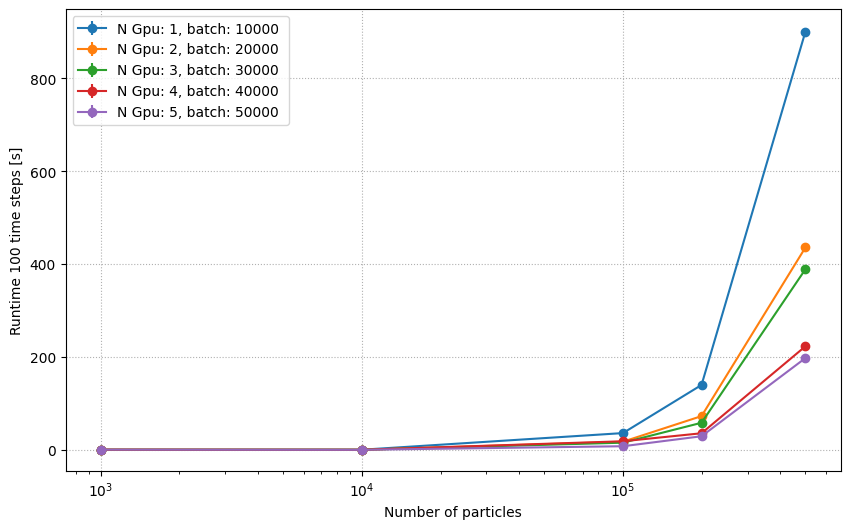

In [56]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np


plt.style.use('default')
pattern = r'\b\w*laxmap\w*\b'
dir_path = './kartick_test_data/h100/100_time_step/'
list_of_string = np.array(sorted([os.path.join(dir_path, f) for f in os.listdir(dir_path)]), dtype='str')
matches = [s for s in list_of_string if re.search(pattern, s)]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for m in matches:
    match = re.search(r'gpu_(\d+)', m)
    gpu_num = int(match.group(1)) if match else None

    laxmap_match = re.search(r'laxmap_(\d+)', m)
    laxmap_num = int(laxmap_match.group(1)) if laxmap_match else None
    data = np.load(m, allow_pickle=True)
    if len(data) == 3:
        N_particles = [100, 1_000, 10_000]
    else:
        N_particles = [1_000, 10_000, 100_000, 200_000, 500_000 ]
    ax.errorbar(N_particles, data[:, 0], yerr=data[:, 1], label=f'N Gpu: {gpu_num}, batch: {laxmap_num} ', marker='o', linestyle='-')
ax.set_xlabel('Number of particles')
ax.set_ylabel('Runtime 100 time steps [s]')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(linestyle='dotted')
ax.legend()
fig.savefig('./laxmap_scalability_100step.pdf', bbox_inches='tight')

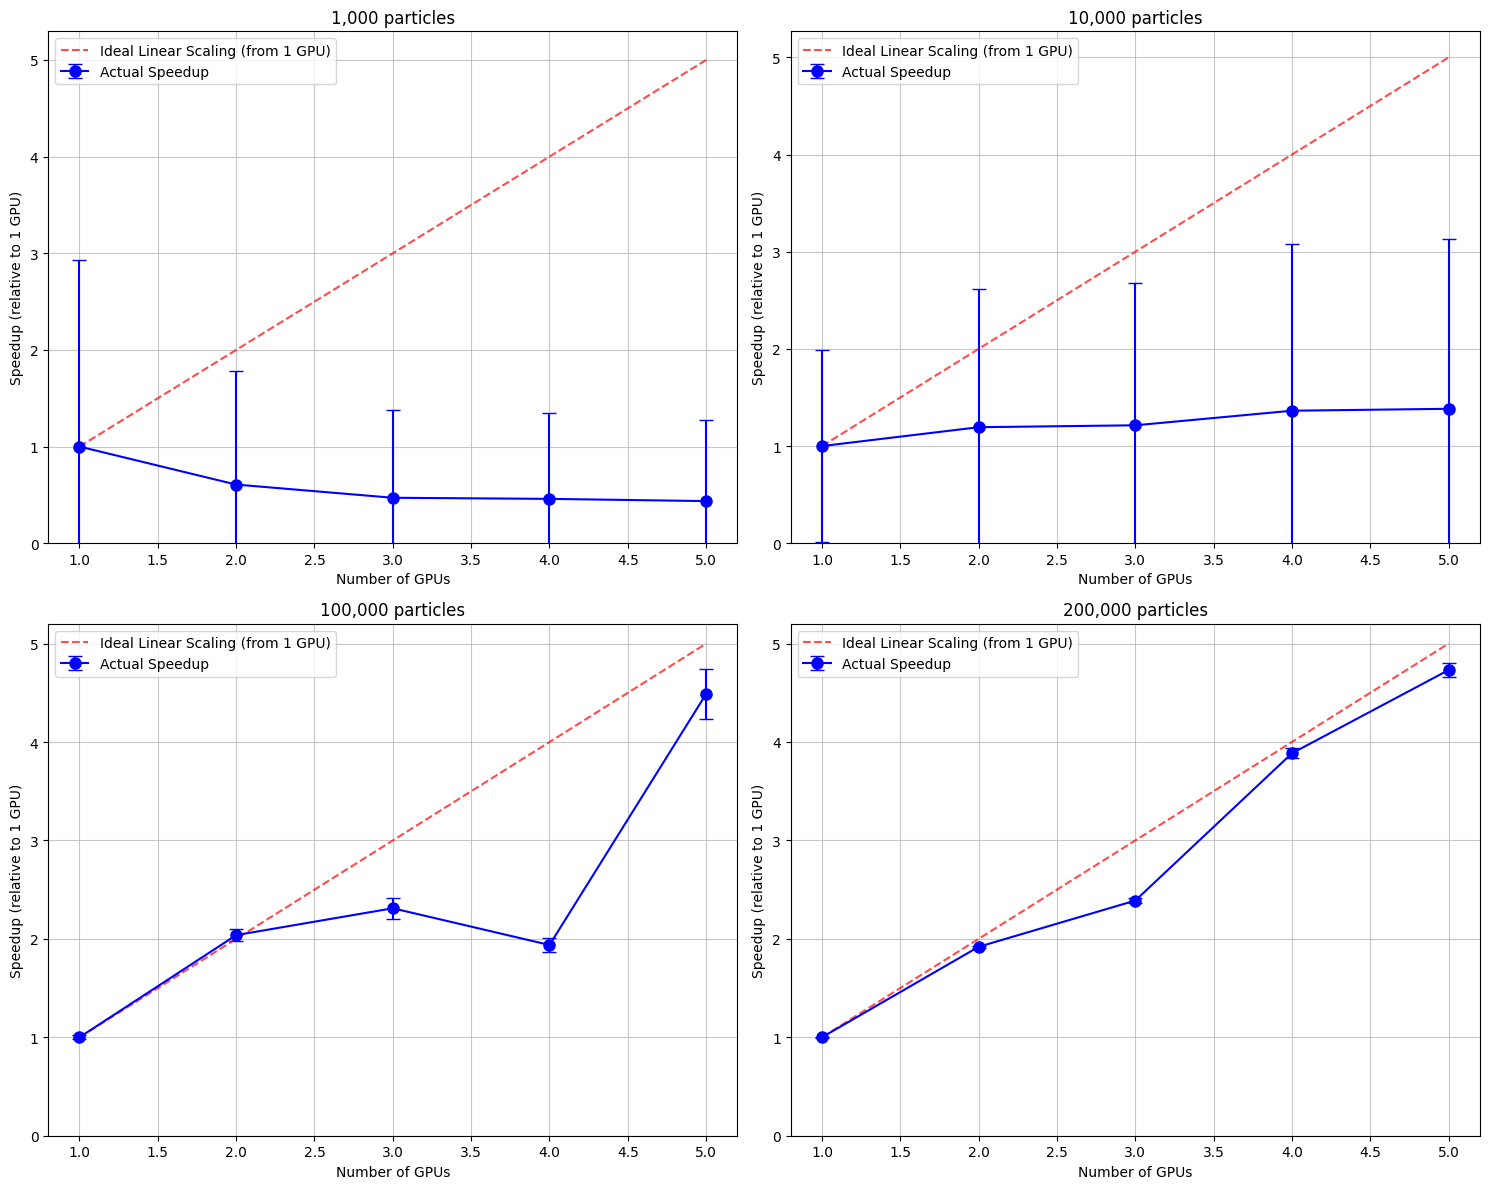


=== GPU SCALING EFFICIENCY (relative to 1 GPU) ===
GPU Count  Particle Count  Speedup    Efficiency  
-------------------------------------------------------
1          1,000           1.00       100.0       %
2          1,000           0.61       30.3        %
3          1,000           0.47       15.7        %
4          1,000           0.46       11.5        %
5          1,000           0.44       8.7         %

1          10,000          1.00       100.0       %
2          10,000          1.19       59.7        %
3          10,000          1.21       40.5        %
4          10,000          1.36       34.1        %
5          10,000          1.38       27.7        %

1          100,000         1.00       100.0       %
2          100,000         2.04       101.9       %
3          100,000         2.31       77.0        %
4          100,000         1.94       48.4        %
5          100,000         4.49       89.8        %

1          200,000         1.00       100.0       %
2     

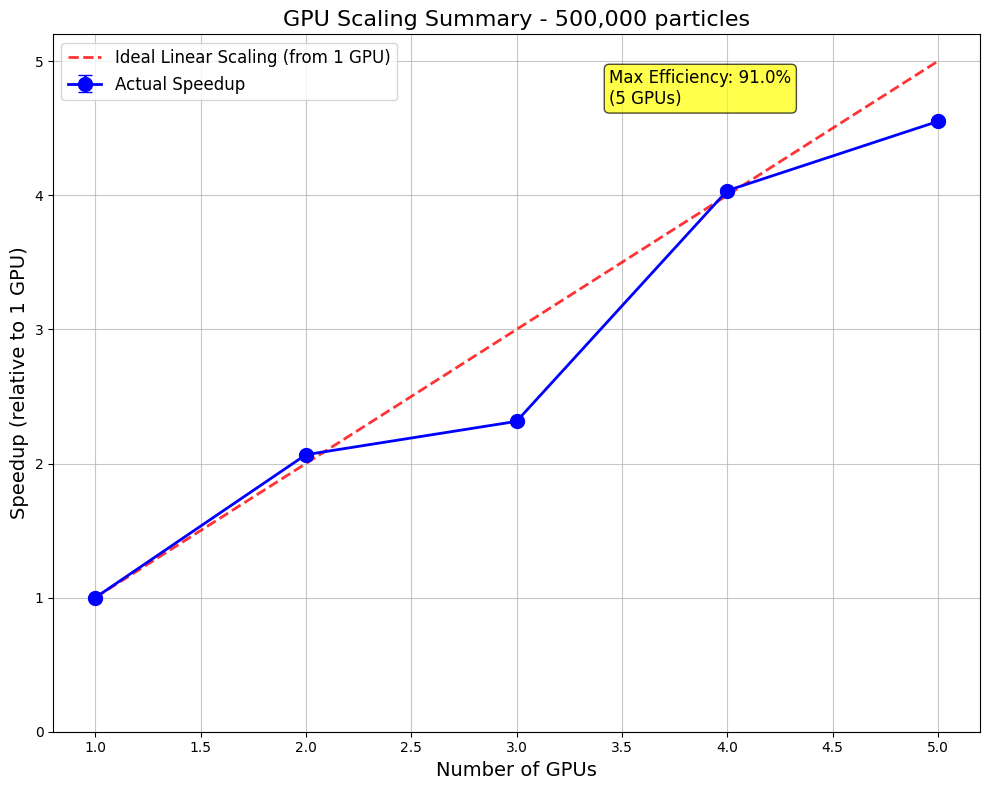

In [53]:
import re
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
pattern = r'\b\w*laxmap\w*\b'
dir_path = './kartick_test_data/h100/100_time_step/'
list_of_string = np.array(sorted([os.path.join(dir_path, f) for f in os.listdir(dir_path)]), dtype='str')
matches = [s for s in list_of_string if re.search(pattern, s)]

matches = [s for s in list_of_string if re.search(pattern, s)]

# Dictionary to store data organized by GPU count
gpu_data = {}

# Load and organize data by GPU count
for m in matches:
    match = re.search(r'gpu_(\d+)', m)
    gpu_num = int(match.group(1)) if match else None
    
    data = np.load(m, allow_pickle=True)
    if len(data) == 3:
        N_particles = [100, 1_000, 10_000]
    else:
        N_particles = [1_000, 10_000, 100_000, 200_000, 500_000 ]
    
    gpu_data[gpu_num] = data

# Sort GPU numbers to ensure consistent ordering
gpu_numbers = sorted(gpu_data.keys())

# Find baseline (1 GPU) data
baseline_gpu = 1  # Always use 1 GPU as baseline
if baseline_gpu not in gpu_data:
    print(f"Warning: No data found for {baseline_gpu} GPU baseline")
    baseline_gpu = min(gpu_numbers)  # Use minimum GPU count as fallback
    print(f"Using {baseline_gpu} GPU(s) as baseline instead")

baseline_data = gpu_data[baseline_gpu]

# Create GPU scaling plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Plot speedup for each particle count
for particle_idx, n_particles in enumerate(N_particles):
    if particle_idx >= len(axes):
        break
        
    ax = axes[particle_idx]
    
    gpu_counts = []
    speedups = []
    speedup_errors = []
    
    # Get baseline time for this particle count
    baseline_time = baseline_data[particle_idx, 0]
    baseline_error = baseline_data[particle_idx, 1]
    
    for gpu_count in gpu_numbers:
        data = gpu_data[gpu_count]
        runtime_mean = data[particle_idx, 0]
        runtime_std = data[particle_idx, 1]
        
        # Calculate speedup relative to 1 GPU baseline
        speedup = baseline_time / runtime_mean
        
        # Error propagation for speedup
        speedup_error = speedup * np.sqrt((baseline_error/baseline_time)**2 + (runtime_std/runtime_mean)**2)
        
        gpu_counts.append(gpu_count)
        speedups.append(speedup)
        speedup_errors.append(speedup_error)
    
    # Plot the scaling
    ax.errorbar(gpu_counts, speedups, yerr=speedup_errors, 
               marker='o', linestyle='-', capsize=5, markersize=8,
               color='blue', label='Actual Speedup')
    
    # Add ideal linear scaling line (relative to baseline)
    ideal_speedup = np.array(gpu_counts) / baseline_gpu
    ax.plot(gpu_counts, ideal_speedup, '--', color='red', alpha=0.7, 
           label=f'Ideal Linear Scaling (from {baseline_gpu} GPU)')
    
    ax.set_xlabel('Number of GPUs')
    ax.set_ylabel(f'Speedup (relative to {baseline_gpu} GPU)')
    ax.set_title(f'{n_particles:,} particles')
    ax.grid(True, alpha=0.7)
    ax.legend()
    ax.set_ylim(bottom=0)

# Hide unused subplots
for i in range(len(N_particles), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
fig.savefig('./gpu_scaling_matrix_relative_to_1gpu.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Print efficiency summary
print(f"\n=== GPU SCALING EFFICIENCY (relative to {baseline_gpu} GPU) ===")
print(f"{'GPU Count':<10} {'Particle Count':<15} {'Speedup':<10} {'Efficiency':<12}")
print("-" * 55)

for particle_idx, n_particles in enumerate(N_particles):
    baseline_time = baseline_data[particle_idx, 0]
    
    for gpu_count in gpu_numbers:
        data = gpu_data[gpu_count]
        runtime_mean = data[particle_idx, 0]
        
        speedup = baseline_time / runtime_mean
        efficiency = (speedup / (gpu_count / baseline_gpu)) * 100
        
        print(f"{gpu_count:<10} {n_particles:<15,} {speedup:<10.2f} {efficiency:<12.1f}%")
    print()

# Create a summary plot for the largest particle count
fig2, ax2 = plt.subplots(figsize=(10, 8))

# Use the largest particle count for summary
largest_particle_idx = -1  # Last index
n_particles_summary = N_particles[largest_particle_idx]

gpu_counts = []
speedups = []
speedup_errors = []

baseline_time = baseline_data[largest_particle_idx, 0]
baseline_error = baseline_data[largest_particle_idx, 1]

for gpu_count in gpu_numbers:
    data = gpu_data[gpu_count]
    runtime_mean = data[largest_particle_idx, 0]
    runtime_std = data[largest_particle_idx, 1]
    
    speedup = baseline_time / runtime_mean
    speedup_error = speedup * np.sqrt((baseline_error/baseline_time)**2 + (runtime_std/runtime_mean)**2)
    
    gpu_counts.append(gpu_count)
    speedups.append(speedup)
    speedup_errors.append(speedup_error)

# Plot actual speedup
ax2.errorbar(gpu_counts, speedups, yerr=speedup_errors, 
            marker='o', linestyle='-', capsize=5, markersize=10, linewidth=2,
            color='blue', label='Actual Speedup')

# Add ideal linear scaling
ideal_speedup = np.array(gpu_counts) / baseline_gpu
ax2.plot(gpu_counts, ideal_speedup, '--', color='red', alpha=0.8, linewidth=2,
        label=f'Ideal Linear Scaling (from {baseline_gpu} GPU)')

ax2.set_xlabel('Number of GPUs', fontsize=14)
ax2.set_ylabel(f'Speedup (relative to {baseline_gpu} GPU)', fontsize=14)
ax2.set_title(f'GPU Scaling Summary - {n_particles_summary:,} particles', fontsize=16)
ax2.grid(True, alpha=0.7)
ax2.legend(fontsize=12)
ax2.set_ylim(bottom=0)

# Add efficiency annotation for the highest GPU count
max_gpu = max(gpu_counts)
max_speedup = speedups[-1]
efficiency = (max_speedup / (max_gpu / baseline_gpu)) * 100
ax2.text(0.6, 0.9, f'Max Efficiency: {efficiency:.1f}%\n({max_gpu} GPUs)', 
        transform=ax2.transAxes, fontsize=12, 
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
fig2.savefig('./gpu_scaling_summary_matrix.pdf', bbox_inches='tight', dpi=300)
plt.show()

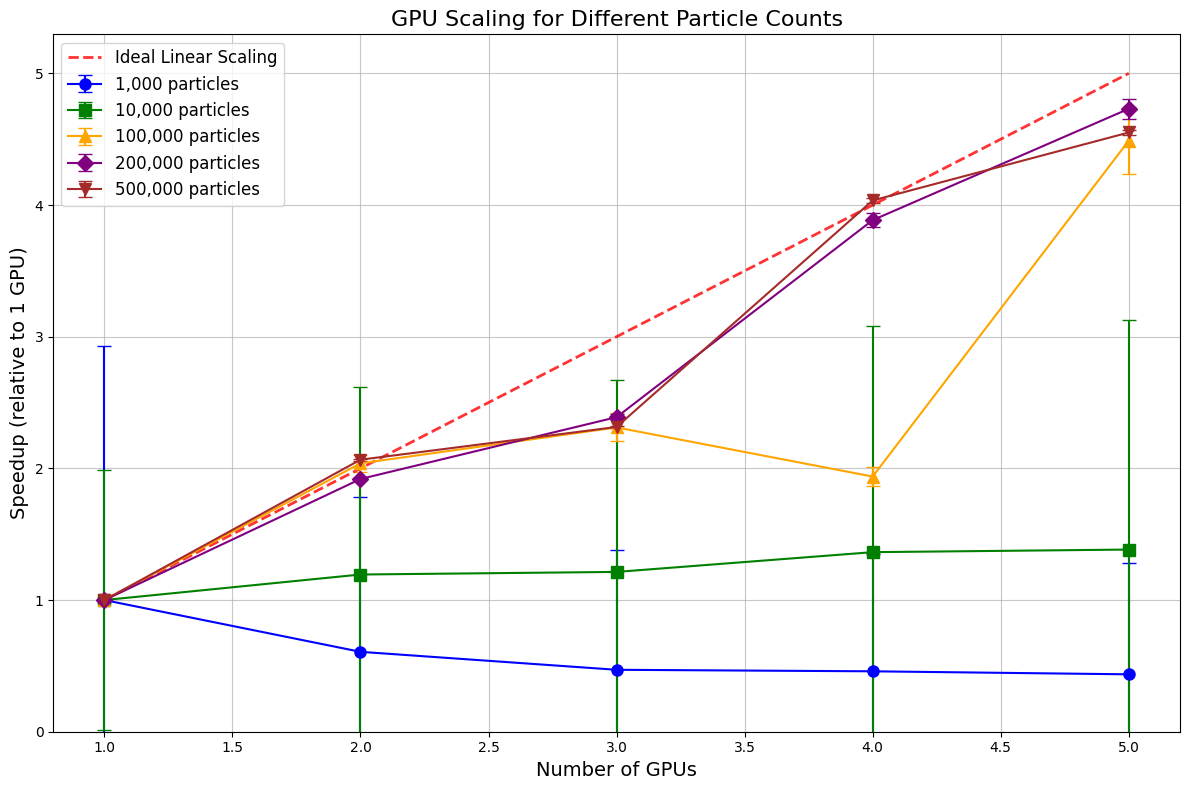


=== GPU SCALING EFFICIENCY (relative to 1 GPU) ===
GPU Count  Particle Count  Speedup    Efficiency  
-------------------------------------------------------
1          1,000           1.00       100.0       %
2          1,000           0.61       30.3        %
3          1,000           0.47       15.7        %
4          1,000           0.46       11.5        %
5          1,000           0.44       8.7         %

1          10,000          1.00       100.0       %
2          10,000          1.19       59.7        %
3          10,000          1.21       40.5        %
4          10,000          1.36       34.1        %
5          10,000          1.38       27.7        %

1          100,000         1.00       100.0       %
2          100,000         2.04       101.9       %
3          100,000         2.31       77.0        %
4          100,000         1.94       48.4        %
5          100,000         4.49       89.8        %

1          200,000         1.00       100.0       %
2     

In [54]:
import re
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
pattern = r'\b\w*laxmap\w*\b'
dir_path = './kartick_test_data/h100/100_time_step/'
list_of_string = np.array(sorted([os.path.join(dir_path, f) for f in os.listdir(dir_path)]), dtype='str')
matches = [s for s in list_of_string if re.search(pattern, s)]

matches = [s for s in list_of_string if re.search(pattern, s)]

# Dictionary to store data organized by GPU count
gpu_data = {}

# Load and organize data by GPU count
for m in matches:
    match = re.search(r'gpu_(\d+)', m)
    gpu_num = int(match.group(1)) if match else None
    
    data = np.load(m, allow_pickle=True)
    if len(data) == 3:
        N_particles = [100, 1_000, 10_000]
    else:
        N_particles = [1_000, 10_000, 100_000, 200_000, 500_000 ]
    
    gpu_data[gpu_num] = data

# Sort GPU numbers to ensure consistent ordering
gpu_numbers = sorted(gpu_data.keys())

# Find baseline (1 GPU) data
baseline_gpu = 1  # Always use 1 GPU as baseline
if baseline_gpu not in gpu_data:
    print(f"Warning: No data found for {baseline_gpu} GPU baseline")
    baseline_gpu = min(gpu_numbers)  # Use minimum GPU count as fallback
    print(f"Using {baseline_gpu} GPU(s) as baseline instead")

baseline_data = gpu_data[baseline_gpu]

# Create single combined GPU scaling plot
fig, ax = plt.subplots(figsize=(12, 8))

# Colors for different particle counts
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink']
markers = ['o', 's', '^', 'D', 'v', '<']

# Plot speedup for each particle count on the same plot
for particle_idx, n_particles in enumerate(N_particles):
    gpu_counts = []
    speedups = []
    speedup_errors = []
    
    # Get baseline time for this particle count
    baseline_time = baseline_data[particle_idx, 0]
    baseline_error = baseline_data[particle_idx, 1]
    
    for gpu_count in gpu_numbers:
        data = gpu_data[gpu_count]
        runtime_mean = data[particle_idx, 0]
        runtime_std = data[particle_idx, 1]
        
        # Calculate speedup relative to 1 GPU baseline
        speedup = baseline_time / runtime_mean
        
        # Error propagation for speedup
        speedup_error = speedup * np.sqrt((baseline_error/baseline_time)**2 + (runtime_std/runtime_mean)**2)
        
        gpu_counts.append(gpu_count)
        speedups.append(speedup)
        speedup_errors.append(speedup_error)
    
    # Plot the scaling with different colors/markers for each particle count
    ax.errorbar(gpu_counts, speedups, yerr=speedup_errors, 
               marker=markers[particle_idx % len(markers)], 
               linestyle='-', capsize=5, markersize=8,
               color=colors[particle_idx % len(colors)], 
               label=f'{n_particles:,} particles')

# Add ideal linear scaling line
if gpu_counts:  # Make sure we have data
    ideal_speedup = np.array(gpu_counts) / baseline_gpu
    ax.plot(gpu_counts, ideal_speedup, '--', color='red', alpha=0.8, linewidth=2,
           label='Ideal Linear Scaling')

ax.set_xlabel('Number of GPUs', fontsize=14)
ax.set_ylabel(f'Speedup (relative to {baseline_gpu} GPU)', fontsize=14)
ax.set_title('GPU Scaling for Different Particle Counts', fontsize=16)
ax.grid(True, alpha=0.7)
ax.legend(fontsize=12)
ax.set_ylim(bottom=0)

plt.tight_layout()
fig.savefig('./gpu_scaling_combined.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Print efficiency summary
print(f"\n=== GPU SCALING EFFICIENCY (relative to {baseline_gpu} GPU) ===")
print(f"{'GPU Count':<10} {'Particle Count':<15} {'Speedup':<10} {'Efficiency':<12}")
print("-" * 55)

for particle_idx, n_particles in enumerate(N_particles):
    baseline_time = baseline_data[particle_idx, 0]
    
    for gpu_count in gpu_numbers:
        data = gpu_data[gpu_count]
        runtime_mean = data[particle_idx, 0]
        
        speedup = baseline_time / runtime_mean
        efficiency = (speedup / (gpu_count / baseline_gpu)) * 100
        
        print(f"{gpu_count:<10} {n_particles:<15,} {speedup:<10.2f} {efficiency:<12.1f}%")
    print()
    

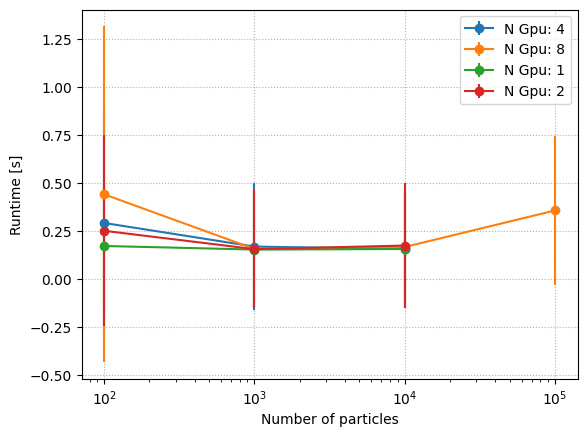

In [30]:
import re
plt.style.use('default')
pattern = r'\b\w*matrix\w*\b'
dir_path = './kartick_test_data/2080Ti/'
list_of_string = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]
matches = [s for s in list_of_string if re.search(pattern, s)]

for m in matches:
    match = re.search(r'gpu_(\d+)', m)
    gpu_num = int(match.group(1)) if match else None

    data = np.load(m, allow_pickle=True)
    if len(data) == 3:
        N_particles = [100, 1_000, 10_000]
    else:
        N_particles = [100, 1_000, 10_000, 100_000]
    plt.errorbar(N_particles, data[:, 0], yerr=data[:, 1], label=f'N Gpu: {gpu_num}', marker='o', linestyle='-')
plt.xlabel('Number of particles')
plt.ylabel('Runtime [s]')
plt.xscale('log')
plt.grid(linestyle='dotted')
plt.legend()
plt.savefig('./matrix_scalability.pdf', bbox_inches='tight')

# DIRECT ACC MASKING

In [5]:
runtime_list_direct_acc_matrix = []
N_particles_list = [50, 100, 500, 1_000, 5_000, 10_000, 50_000, 100_000]
for N_particles in N_particles_list:

    config = SimulationConfig(N_particles=N_particles, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC_MATRIX,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

    params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                            Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                            a=(1 * u.kpc).to(code_units.code_length).value),
                            NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                    r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                    c = 10,),
                            G=G, ) 
    
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(4), params=params, config=config)
    #put the Plummer sphere in a ciruclar orbit around the NFW halo
    rp=100*u.kpc.to(code_units.code_length)

    mass_inside_rp = 4*jnp.pi*params.NFW_params.d_c*params.NFW_params.r_s**3*(jnp.log(1+rp/params.NFW_params.r_s)-rp/(rp+params.NFW_params.r_s))

    if len(config.external_accelerations)>0:
        pos, vel, _ = ic_two_body(mass_inside_rp, params.Plummer_params.Mtot, rp=rp, e=0., config=config, params=params)
        velocities = velocities + vel[1]
        positions = positions + pos[1]

    #initialize the initial state
    initial_state = construct_initial_state(positions, velocities)
    
    snapshots = jax.block_until_ready( time_integration(initial_state, mass, config, params) )
    # Where you're currently using timeit.timeit()
    times = timeit.repeat(
        lambda: jax.block_until_ready(time_integration(initial_state, mass, config, params)),
        repeat=3,  # Number of times to repeat the measurement
        number=2   # Number of calls per measurement
    )

    mean_runtime = np.mean(times)
    std_runtime = np.std(times)
    runtime_list_direct_acc_matrix.append((mean_runtime, std_runtime))

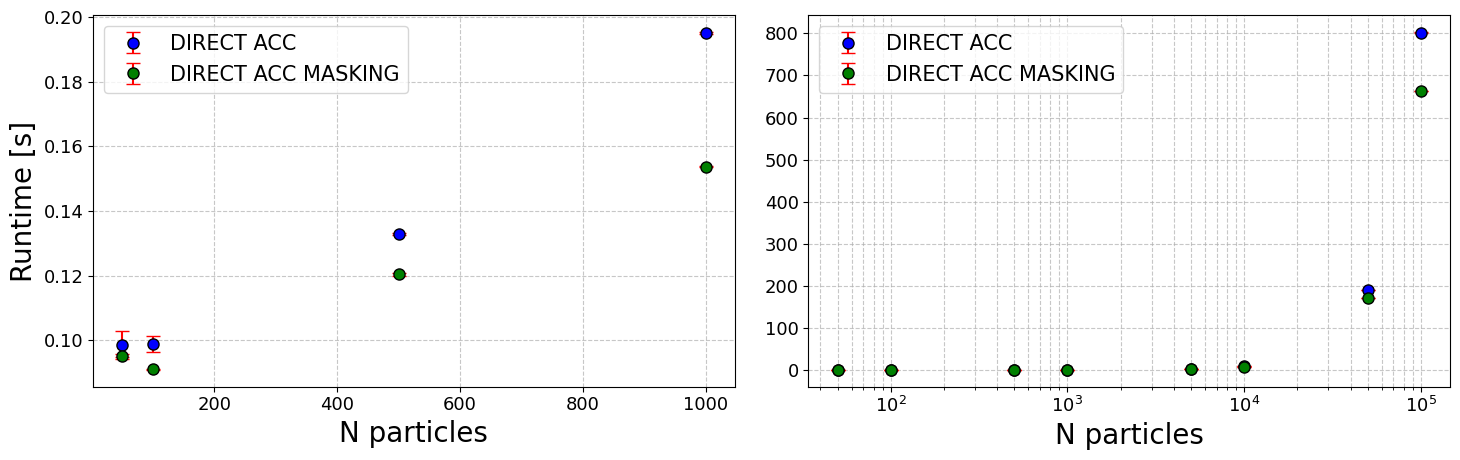

In [12]:
# Extract mean and std from runtime_list tuples
mean_times_acc = [t[0] for t in runtime_list_direct_acc]
std_times_acc = [t[1] for t in runtime_list_direct_acc]

mean_times_acc_masking = [t[0] for t in runtime_list_direct_acc_matrix]
std_times_acc_masking = [t[1] for t in runtime_list_direct_acc_matrix]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax = fig.add_subplot(122)
# Create an error bar plot
ax.errorbar(N_particles_list, mean_times_acc, yerr=std_times_acc, fmt='o', capsize=5, 
             markersize=8, ecolor='red', markeredgecolor='black', markerfacecolor='blue', label='DIRECT ACC')
ax.errorbar(N_particles_list, mean_times_acc_masking, yerr=std_times_acc_masking, fmt='o', capsize=5,
                markersize=8, ecolor='red', markeredgecolor='black', markerfacecolor='green', label='DIRECT ACC MASKING')

# Set scales and labels
ax.set_xscale('log')
ax.set_xlabel('N particles')
# ax.set_ylabel('Runtime [s]')
ax.grid(True, which="both", ls="--", alpha=0.7)
ax.legend()


ax = fig.add_subplot(121)
# Create an error bar plot
ax.errorbar(N_particles_list[:4], mean_times_acc[:4], yerr=std_times_acc[:4], fmt='o', capsize=5, 
             markersize=8, ecolor='red', markeredgecolor='black', markerfacecolor='blue', label='DIRECT ACC')
ax.errorbar(N_particles_list[:4], mean_times_acc_masking[:4], yerr=std_times_acc_masking[:4], fmt='o', capsize=5,
                markersize=8, ecolor='red', markeredgecolor='black', markerfacecolor='green', label='DIRECT ACC MASKING')

# Set scales and labels
# ax.set_xscale('log')
ax.set_xlabel('N particles')
ax.set_ylabel('Runtime [s]')
ax.grid(True, which="both", ls="--", alpha=0.7)
ax.legend()

fig.savefig('runtime_direct_acc_vs_direct_acc_matrix.pdf')

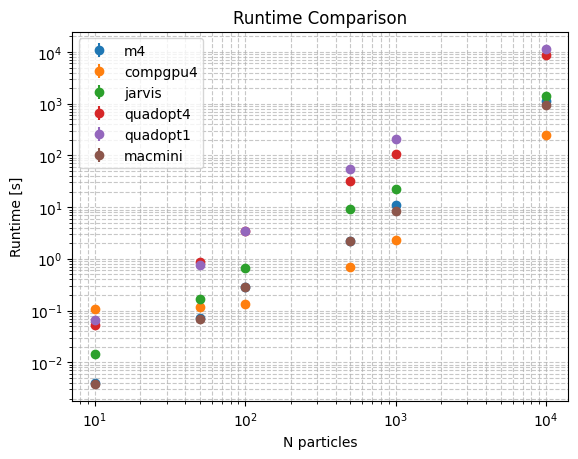

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N_particles_list = [10, 50, 100, 500, 1_000, 10_000]

data_m4 = np.load('./kartick_test_data/m4test.npy')
data_compgpu = np.load('./kartick_test_data/compgpu4.npy')
data_jarvis = np.load('./kartick_test_data/jarvis.npy')
data_quadopt4 = np.load('./kartick_test_data/quadopt4.npy')
data_quadopt1 = np.load('./kartick_test_data/quadopt1.npy')
data_macmini = np.load('./kartick_test_data/macmini.npy')

plt.errorbar(N_particles_list, data_m4[:, 0], data_m4[:, 1], fmt='o', label='m4')
plt.errorbar(N_particles_list, data_compgpu[:, 0], data_compgpu[:, 1], fmt='o', label='compgpu4')
plt.errorbar(N_particles_list, data_jarvis[:, 0], data_jarvis[:, 1], fmt='o', label='jarvis')
plt.errorbar(N_particles_list, data_quadopt4[:, 0], data_quadopt4[:, 1], fmt='o', label='quadopt4')
plt.errorbar(N_particles_list, data_quadopt1[:, 0], data_quadopt1[:, 1], fmt='o', label='quadopt1')
plt.errorbar(N_particles_list, data_macmini[:, 0], data_macmini[:, 1], fmt='o', label='macmini')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N particles')
plt.ylabel('Runtime [s]')
plt.title('Runtime Comparison')
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.legend()
plt.savefig('./kartick_test_data/runtime_comparison_10e4.pdf')

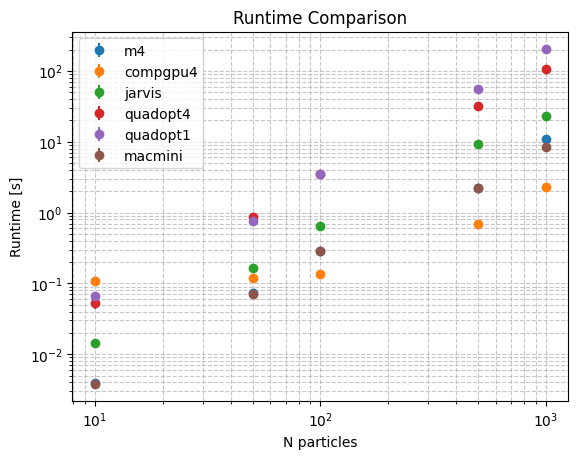

In [3]:
import numpy as np
import matplotlib.pyplot as plt

N_particles_list = [10, 50, 100, 500, 1_000, ]

data_m4 = np.load('./kartick_test_data/m4test.npy')
data_compgpu = np.load('./kartick_test_data/compgpu4.npy')
data_jarvis = np.load('./kartick_test_data/jarvis.npy')
data_quadopt4 = np.load('./kartick_test_data/quadopt4.npy')
data_quadopt1 = np.load('./kartick_test_data/quadopt1.npy')
data_macmini = np.load('./kartick_test_data/macmini.npy')

plt.errorbar(N_particles_list, data_m4[:-1, 0], data_m4[:-1, 1], fmt='o', label='m4')
plt.errorbar(N_particles_list, data_compgpu[:-1, 0], data_compgpu[:-1, 1], fmt='o', label='compgpu4')
plt.errorbar(N_particles_list, data_jarvis[:-1, 0], data_jarvis[:-1, 1], fmt='o', label='jarvis')
plt.errorbar(N_particles_list, data_quadopt4[:-1, 0], data_quadopt4[:-1, 1], fmt='o', label='quadopt4')
plt.errorbar(N_particles_list, data_quadopt1[:-1, 0], data_quadopt1[:-1, 1], fmt='o', label='quadopt1')
plt.errorbar(N_particles_list, data_macmini[:-1, 0], data_macmini[:-1, 1], fmt='o', label='macmini')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('N particles')
plt.ylabel('Runtime [s]')
plt.title('Runtime Comparison')
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.legend()
plt.savefig('./kartick_test_data/runtime_comparison_10e3.pdf')